In [45]:
include("../scripts/kf.jl")

draw (generic function with 9 methods)

In [2]:
function make_ax()
    fig, ax = subplots()
    ax.set_aspect("equal")
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_xlabel("X", fontsize=20)
    ax.set_ylabel("Y", fontsize=20)
    return ax
end

make_ax (generic function with 1 method)

In [3]:
function draw_trajectory(xs, ax)
    poses = [xs[s] for s in 1:length(xs)]
    ax.scatter([e[1] for e in poses], [e[2] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[1] for e in poses], [e[2] for e in poses], linewidth=0.5, color="black")
end

draw_trajectory (generic function with 1 method)

In [4]:
function draw_observations(xs, zlist, ax)
    for s in 1:length(xs)
        if !haskey(zlist, s)
            continue
        end
        for obs in zlist[s]
            x,y,theta = xs[s]
            ell,phi = obs[2][1], obs[2][2]
            mx = x + ell*cos(theta+phi)
            my = y + ell*sin(theta+phi)
            ax.plot([x,mx],[y,my], color="pink", alpha=0.5)
        end
    end
end

draw_observations (generic function with 1 method)

In [80]:
function read_data()
    f = open("log_for_book.txt", "r")
    lines = readlines(f)
    hat_xs = Dict()
    zlist = Dict()
    for line in lines
        tmp = split(line)
        step = parse(Int, tmp[2]) + 1#for 1-indexed
        if tmp[1] == "x"
            hat_xs[step] = [parse(Float64, tmp[3]), 
                parse(Float64, tmp[4]), parse(Float64, tmp[5])]
        elseif tmp[1] == "z"
            if !haskey(zlist, step)
                zlist[step] = []
            end
            push!(zlist[step], (parse(Int, tmp[3]), [parse(Float64, tmp[4]), 
                parse(Float64, tmp[5]), parse(Float64, tmp[6])]))
        end
    end
    return hat_xs, zlist
end

read_data (generic function with 1 method)

In [81]:
mutable struct ObsEdge
    t1
    t2
    x1
    x2
    z1
    z2
end

In [82]:
function ObsEdge_(t1,t2,z1,z2,xs)
    @assert z1[1] == z2[1]
    self = ObsEdge(ntuple(x->nothing, fieldcount(ObsEdge))...)
    self.t1, self.t2 = t1, t2
    self.x1, self.x2 = xs[t1], xs[t2]
    self.z1, self.z2 = z1[2], z2[2]
    return self
end

ObsEdge_ (generic function with 1 method)

In [2]:
function make_edges(hat_xs, zlist)
    landmark_keys_zlist = Dict()
    for step in keys(zlist)
        for z in zlist[step]
            landmark_id = z[1]
            if !haskey(landmark_keys_zlist,landmark_id)
                landmark_keys_zlist[landmark_id] = []
            end
            push!(landmark_keys_zlist[landmark_id],(step,z))
        end
    end

    edges = []
    for landmark_id in keys(landmark_keys_zlist)
        for i in 1:length(landmark_keys_zlist[landmark_id])
            for j in i+1:length(landmark_keys_zlist[landmark_id])
                xz1 = landmark_keys_zlist[landmark_id][i]
                xz2 = landmark_keys_zlist[landmark_id][j]
                push!(edges, ObsEdge_(xz1[1], xz2[1], xz1[2], xz2[2], hat_xs))
            end
        end
    end
    return edges
end

make_edges (generic function with 1 method)

In [3]:
function draw_edges(edges, ax)
    for e in edges
        ax.plot([e.x1[1], e.x2[1]], [e.x1[2], e.x2[2]], color="red", alpha=0.5)
    end
end

draw_edges (generic function with 1 method)

In [4]:
function draw(xs, zlist, edges)
    ax = make_ax()
    draw_observations(xs, zlist, ax)
    draw_edges(edges, ax)
    draw_trajectory(xs, ax)
end

draw (generic function with 1 method)

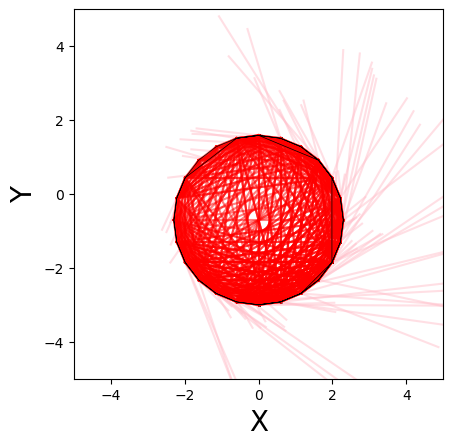

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb09484a850>

In [86]:
hat_xs, zlist = read_data()
edges = make_edges(hat_xs, zlist)
draw(hat_xs, zlist, edges)